## <b>Weather forecast project 

# <b>03 - SIMPLE MODELING TECHNIQUES

# Rain in Australia
---
#### Dataset source:

Les deux datasets issus de l'étape de feature engineering seront utilisés dans ce notebook : 
    
    - data_features.csv contenant les données nettoyées et préparées sur la base du dataset initiale
    
    - pca_data_features.csv issu de l'analyse PCA

#### Context:

> <div class= "alert alert-block alert-info"> <b>Modélisations simples</b> 
Ce notebook regroupe les résultats obtenus avec des modèles simples de classification. On compare les résultats obtenus par une simples régression logistique avec les modèles SVC, DecisionTree, RandomForest et KnNeighbors.    
Ces différents modèles font ensuite l'objet d'une otpimisation de leur hyperparamètres respectifs.
</div>

Dans cette partie, faute de connaissance métier, nous avons fait le choix de mesurer la performance des différents modèles sur la metric "f1-weighted" pour mieux tenir compte du déséquilibre de classe du dataset initial. Ce choix amène naturellement à mieux représenter la classe "absence de pluie le lendemain". Les travaux contenus dans le notebook "model_for_imbalanced_data" amèneront à discuter la modélisation pour mieux modélisation la classe "présence de pluie le lendemain".


# [Table of contents](#0)<a name="0"></a> 
1. [Titre 1 ](#1)
2. [Titre 2](#2)

#### Packages nécessaires au notebook :

In [77]:
import numpy as np
import numpy as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time
import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression,f_classif,chi2

from skopt import BayesSearchCV
from skopt.space import Real, Integer

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [78]:
import pandas as pd

url = "https://raw.githubusercontent.com/WeatherForecasterTeam/australia_weather_forecasts/main/data/data_features.csv"
df = pd.read_csv(url, index_col=0)

url_pca = "https://raw.githubusercontent.com/WeatherForecasterTeam/australia_weather_forecasts/main/data/pca_data_features2.csv"
df_pca = pd.read_csv(url_pca, index_col=0)

In [80]:
# df = pd.read_csv("../data/data_features.csv", index_col=0)
# df_pca = pd.read_csv("../data/pca_data_features2.csv", index_col = 0) 

In [11]:
df.head()

,sunshine,windgustspeed,humidity3pm,pressure3pm,year,windspeed3pm,temp_amplitude,cloud3pm,rainfall,climat,...,cloud9am,winddir9am_sin,latitude,month,geography,raintoday,evaporation,windspeed9am,windgustdir_cos,raintomorrow
0,10.90,44.00,22.00,1007.10,2008,24.00,9.50,7.00,0.60,0,...,8.00,0.00,-36.07,12,0,0,7.60,20.00,-1.00,0
1,12.90,44.00,25.00,1007.80,2008,22.00,17.70,1.00,0.00,0,...,1.00,0.92,-36.07,12,0,0,12.00,4.00,-0.92,0
2,8.00,46.00,30.00,1008.70,2008,26.00,12.80,2.00,0.00,0,...,7.00,0.00,-36.07,12,0,0,8.00,19.00,-0.92,0
3,2.20,24.00,16.00,1012.80,2008,9.00,18.80,6.00,0.00,0,...,8.00,-0.71,-36.07,12,0,0,10.00,11.00,0.71,0
4,6.70,41.00,33.00,1006.00,2008,20.00,14.80,8.00,1.00,0,...,7.00,0.38,-36.07,12,0,0,4.80,7.00,-1.00,0


In [12]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.52,2.19,0.40,-1.63,1.22,-0.90,-0.04,1.39,2.29,-0.55,...,0.10,0.05,-1.28,-0.24,0.18,-1.25,-0.49,0.45,-1.39,0.63
1,-3.01,0.56,0.71,-1.93,1.86,-1.07,0.18,1.22,2.18,-1.14,...,-0.97,0.48,0.92,-1.00,-0.42,0.25,0.58,0.02,-0.13,-0.01
2,-1.02,2.08,0.44,-1.36,0.75,-1.99,-0.19,1.50,2.22,-0.49,...,-0.27,0.41,-0.86,-0.97,0.52,0.59,-0.04,-0.43,0.15,-0.09
3,-0.92,-0.87,-0.78,-0.26,-0.88,0.84,-0.00,1.62,4.31,0.81,...,0.12,0.47,-0.78,-0.16,0.10,0.34,0.69,-1.17,-0.12,0.03
4,1.23,0.59,0.48,-1.83,1.16,1.49,-0.32,1.23,2.70,-0.44,...,1.38,-1.07,0.24,-0.55,-0.17,-0.40,-0.03,0.29,-0.96,1.46


In [13]:
df.shape

(72707, 24)

# 1. Préparation des données <a name="1"></a>
[return to the plan](#0)  

Préparation des données en vue des modélisations 
* Séparation des données en variables explicatives et variables cibles
* Fractionnement des données en ensemble d'entraînement et de test
* Normalisation si nécessaire

In [79]:
# Séparation des données
# dataset optimisé
X = df.drop(['raintomorrow'],axis=1)
y = df['raintomorrow']

# dataset optimisé en pca
X_pca = df_pca
y_pca = y # y_pca = y = raintomorow, variable cible

# Fractionnement des données 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size = 0.2, random_state = 10)

# Normalisation (Déjà faite dans le cas du PCA)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
# Taille des données d'entraînement et de test :

print("dataset optimisé :")
print("Length of Training Data: {}".format(len(X_train)))
print("Length of Testing Data: {}".format(len(X_test)))
print("\n")
print("dataset optimisé PCA :")
print("Length of Training PCA Data: {}".format(len(X_train_pca)))
print("Length of Testing PCA Data: {}".format(len(X_test_pca)))

dataset optimisé :
Length of Training Data: 58165
Length of Testing Data: 14542


dataset optimisé PCA :
Length of Training PCA Data: 58165
Length of Testing PCA Data: 14542


# 2. Régression logistique<a name="2"></a>
[return to the plan](#0)  

Pour avoir une base de comparaison avec des modélisations plus complexes, nous commencons par utiliser un modèle de régression logistique simple sur df

In [16]:
model = LogisticRegression()

model.fit(X_train,y_train)
y_pred=model.predict(X_test)
f1_weighted=f1_score(y_test,y_pred, average='weighted')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     12240
           1       0.68      0.38      0.49      2302

    accuracy                           0.87     14542
   macro avg       0.79      0.67      0.71     14542
weighted avg       0.86      0.87      0.86     14542



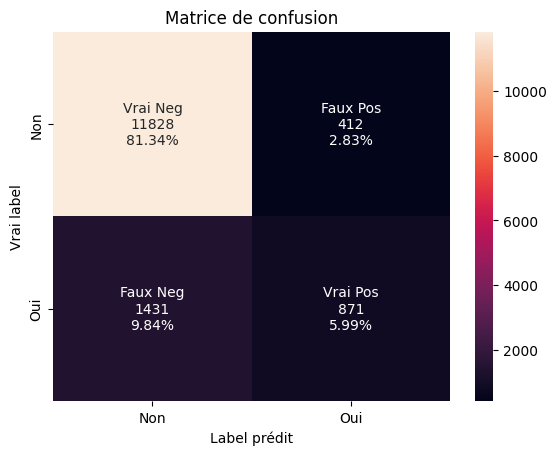

In [17]:
cm = confusion_matrix(y_test,y_pred)

group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

categories = ['Non','Oui']

sns.heatmap(cm, annot=labels, fmt='',xticklabels=categories,yticklabels=categories)
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.title('Matrice de confusion')
plt.show()

Les résultats globaux sont satifaisants mais : 
* Il existe un gros déséquilibre de classe derrière ce score élevé
* Le rappel de la classe 1 est très mauvais

In [29]:
Une premiere tentavive interprétabilité du modèle ici ????? Voir masterclass

SyntaxError: invalid syntax (3836940341.py, line 1)

# 3. Comparaison avec d'autres modèles de machine learning <a name="2"></a>
[return to the plan](#0)  

In [18]:
#Fonction récurrente d'évaluation des modèles

def evaluate(df_print,name,model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    accuracy=model.score(X_test,y_test)
    y_pred=model.predict(X_test)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    f1_weighted=f1_score(y_test,y_pred, average='weighted')
    
    #print(model)
    #print(classification_report(y_test, y_pred))

    df1 = pd.DataFrame({
    "données utilisées": [name],
    "nom du modèle": [model],
    'accuracy':[accuracy],
    'f1_weighted': [f1_weighted], 
    'recall':[recall],
    'f1':[f1] 
    })
        
    return(df1)

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
df_print = pd.DataFrame(columns=['données utilisées', 'nom du modèle', 'f1_weighted', 'accuracy', 'recall', 'f1'])
lr = LogisticRegression()
svm = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

models = [lr, dt, knn, svm, rf]

for model in models:
    df_print = df_print.append(evaluate(df_print, "Modèle sur df", model, X_train, y_train, X_test, y_test))
    df_print = df_print.append(evaluate(df_print, "Modèle sur df_PCA", model, X_train_pca, y_train_pca, X_test_pca, y_test_pca))

df_print = pd.concat([df_print], sort=False)

In [21]:
df_print["nom_rac"]=["Lr","Lr","Dtc","Dtc","Knn","Knn","Svm","Svm","Rf",'Rf']
df_print.head(10)

,données utilisées,nom du modèle,f1_weighted,accuracy,recall,f1,nom_rac
0,Modèle sur df,LogisticRegression(),0.86,0.87,0.38,0.49,Lr
0,Modèle sur df_PCA,LogisticRegression(),0.86,0.87,0.37,0.48,Lr
0,Modèle sur df,DecisionTreeClassifier(),0.82,0.82,0.48,0.46,Dtc
0,Modèle sur df_PCA,DecisionTreeClassifier(),0.81,0.81,0.43,0.42,Dtc
0,Modèle sur df,KNeighborsClassifier(),0.86,0.87,0.38,0.48,Knn
0,Modèle sur df_PCA,KNeighborsClassifier(),0.86,0.87,0.37,0.48,Knn
0,Modèle sur df,SVC(),0.86,0.88,0.36,0.49,Svm
0,Modèle sur df_PCA,SVC(),0.86,0.88,0.35,0.49,Svm
0,Modèle sur df,"(DecisionTreeClassifier(max_features='sqrt', r...",0.86,0.88,0.37,0.50,Rf
0,Modèle sur df_PCA,"(DecisionTreeClassifier(max_features='sqrt', r...",0.86,0.88,0.33,0.46,Rf


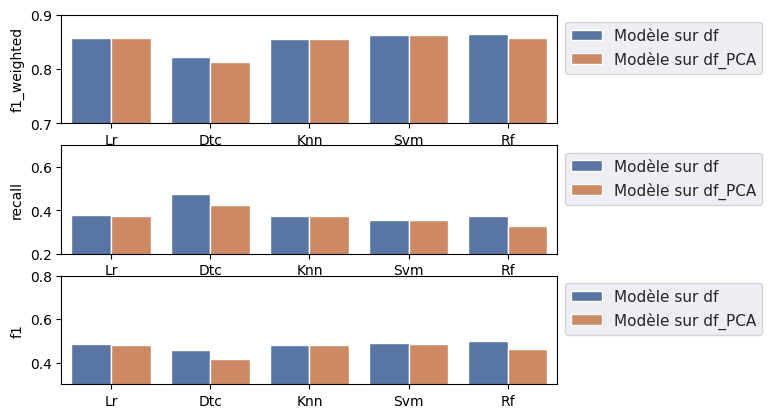

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1)

sns.set(rc={"figure.figsize":(7, 10)})

aa = sns.barplot(data=df_print, x="nom_rac", y="f1_weighted", hue="données utilisées", ax=axes[0])
aa.legend(loc='upper left', bbox_to_anchor=(1, 1))
aa.set_xlabel("", fontsize=10)
aa.set_ylim([0.7, 0.9])

ab = sns.barplot(data=df_print, x="nom_rac", y="recall", hue="données utilisées", ax=axes[1])
ab.legend(loc='upper left', bbox_to_anchor=(1, 1))
ab.set_xlabel("", fontsize=10)
ab.set_ylim([0.2, 0.7])

ac = sns.barplot(data=df_print, x="nom_rac", y="f1", hue="données utilisées", ax=axes[2])
ac.legend(loc='upper left', bbox_to_anchor=(1, 1))
ac.set_xlabel("", fontsize=10)
ac.set_ylim([0.3, 0.8])

plt.show()

Performances assez homogènes sur f1_weighted à part pour DecisionTree. Vainqueur : randomForest

Peu d'intérêt au travail sur PCA avec ce jeu de données (à 90% ou même à 99%)


# 4. Optimisation des modèles <a name="2"></a>
[return to the plan](#0)  

## 4.1 Gridsearch <a name="4.1"></a>
[return to the plan](#1)  

Pour chacun des modèles suivants, on cherche à optimiser leurs hyperparamètres pour chaque jeu de données :
* Logistic Regression
* DecisionTree 
* Kn-Neighbors
* SVM
* Random Forest

In [23]:
for name, X_tr, y_tr, X_te, y_te in zip(['df', 'df_PCA'], [X_train, X_train_pca], [y_train, y_train_pca], [X_test, X_test_pca], [y_test, y_test_pca]):
    logistic_params = {
        "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        "penalty": ['l1', 'l2', 'elasticnet'],
        'C': [100, 10, 1.0, 0.1, 0.01],
        "class_weight": ['balanced', None]
    }

    # apply gridsearch model
    lr_grid = GridSearchCV(LogisticRegression(), logistic_params, scoring='f1_weighted', cv=4)

    lr_grid.fit(X_tr, y_tr)
    lr_grid.best_estimator_
    y_pred = lr_grid.predict(X_te)

    best_score = lr_grid.best_score_
    best_params = lr_grid.best_params_
    precision = precision_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_pred)
    recall = recall_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    print(name)
    print('--')
    print(f'f1_weighted sur Train =: {round(lr_grid.score(X_tr, y_tr) * 100, 2)}%')
    print(f'f1_weighted sur Test =: {round(lr_grid.score(X_te, y_te) * 100, 2)}%')
    print('--')
    print('Best Parameters is', best_params)
    print('--')
    print('ROC Score is', roc)
    print('--')
    print('Recall Score is ', recall)
    print('--')
    print('Confusion Matrix\n\n', cm)
    print('\n\n')

df
--
f1_weighted sur Train =: 86.0%
f1_weighted sur Test =: 85.78%
--
Best Parameters is {'C': 100, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
--
ROC Score is 0.6723532534936941
--
Recall Score is  0.3783666377063423
--
Confusion Matrix

 [[11828   412]
 [ 1431   871]]



df_PCA
--
f1_weighted sur Train =: 85.91%
f1_weighted sur Test =: 85.7%
--
Best Parameters is {'C': 100, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
--
ROC Score is 0.6698972689278434
--
Recall Score is  0.37271937445699393
--
Confusion Matrix

 [[11837   403]
 [ 1444   858]]





In [24]:
#Decision Tree

for name,X_tr,y_tr,X_te,y_te in zip(['df','df_PCA'],[X_train,X_train_pca],[y_train,y_train_pca],[X_test,X_test_pca],[y_test,y_test_pca]):

    tree_params  = {
    "criterion" : ['gini', 'entropy', 'log_loss'],
    "max_depth" : [40,100, None],
    'splitter' : ['best', 'random'],
    'max_features' : ["auto",'sqrt', 'log2',None],
    'random_state' : [4,5],
    'max_leaf_nodes' : [5,10,None],
    'class_weight': ['balanced',None]
    }

    # apply gridsearch model 
    tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, scoring = 'f1_weighted',cv = 4)

    tree_grid.fit(X_tr, y_tr)
    tree_grid.best_estimator_
    y_pred = tree_grid.predict(X_te)

    best_score = tree_grid.best_score_
    best_params = tree_grid.best_params_
    precision = precision_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_pred)
    recall = recall_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    print(name)
    print ('--')
    print(f'f1_weighted sur Train =: {round(tree_grid.score(X_tr, y_tr) * 100, 2)}%')
    print(f'f1_weighted sur Test =: {round(tree_grid.score(X_te, y_te) * 100, 2)}%')
    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)
    print ('\n\n')

df
--
f1_weighted sur Train =: 84.77%
f1_weighted sur Test =: 84.48%
--
Best Parameters is {'class_weight': None, 'criterion': 'entropy', 'max_depth': 40, 'max_features': None, 'max_leaf_nodes': 10, 'random_state': 4, 'splitter': 'best'}
--
ROC Score is 0.6455128177827748
--
Recall Score is  0.3262380538662033
--
Confusion Matrix

 [[11809   431]
 [ 1551   751]]



df_PCA
--
f1_weighted sur Train =: 82.93%
f1_weighted sur Test =: 83.13%
--
Best Parameters is {'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'max_leaf_nodes': 10, 'random_state': 4, 'splitter': 'best'}
--
ROC Score is 0.6144179826578764
--
Recall Score is  0.2602085143353606
--
Confusion Matrix

 [[11856   384]
 [ 1703   599]]





In [25]:
#Kn Neighbors

for name,X_tr,y_tr,X_te,y_te in zip(['df','df_PCA'],[X_train,X_train_pca],[y_train,y_train_pca],[X_test,X_test_pca],[y_test,y_test_pca]):

    kneig_params  = {
    "n_neighbors" : [5,10,15,20],
    "weights" : ['uniform', 'distance'],
    'metric' : ['euclidean', 'minkowski']
    }

    # apply gridsearch model 
    kn_grid = GridSearchCV(KNeighborsClassifier(), kneig_params, scoring = 'f1_weighted',cv = 4)

    kn_grid.fit(X_tr, y_tr)
    kn_grid.best_estimator_
    y_pred = kn_grid.predict(X_te)

    best_score = kn_grid.best_score_
    best_params = kn_grid.best_params_
    precision = precision_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_pred)
    recall = recall_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    print(name)
    print ('--')
    print(f'f1_weighted sur Train =: {round(kn_grid.score(X_tr, y_tr) * 100, 2)}%')
    print(f'f1_weighted sur Test =: {round(kn_grid.score(X_te, y_te) * 100, 2)}%')
    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)
    print ('\n\n')

df
--
f1_weighted sur Train =: 100.0%
f1_weighted sur Test =: 85.8%
--
Best Parameters is {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
--
ROC Score is 0.6648985962760429
--
Recall Score is  0.3557775847089487
--
Confusion Matrix

 [[11922   318]
 [ 1483   819]]



df_PCA
--
f1_weighted sur Train =: 100.0%
f1_weighted sur Test =: 85.83%
--
Best Parameters is {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
--
ROC Score is 0.6667567772837487
--
Recall Score is  0.36055603822762816
--
Confusion Matrix

 [[11909   331]
 [ 1472   830]]





In [26]:
#SVC

for name,X_tr,y_tr,X_te,y_te in zip(['df','df_PCA'],[X_train,X_train_pca],[y_train,y_train_pca],[X_test,X_test_pca],[y_test,y_test_pca]):

    SVM_params  = {
    "kernel" : ['rbf', 'poly', 'sigmoid'],
    "degree" : [3,5],
    "C": [10.0, 1.0, 0.1],
    'class_weight': ['balanced',None]
    }

    # apply gridsearch model 
    svm_grid = GridSearchCV(SVC(), SVM_params, scoring = 'f1_weighted',cv = 4)

    svm_grid.fit(X_tr, y_tr)
    svm_grid.best_estimator_
    y_pred = svm_grid.predict(X_te)

    best_score = svm_grid.best_score_
    best_params = svm_grid.best_params_
    precision = precision_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_pred)
    recall = recall_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    print(name)
    print ('--')
    print(f'f1_weighted sur Train =: {round(svm_grid.score(X_tr, y_tr) * 100, 2)}%')
    print(f'f1_weighted sur Test =: {round(svm_grid.score(X_te, y_te) * 100, 2)}%')
    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)
    print ('\n\n')

df
--
f1_weighted sur Train =: 91.24%
f1_weighted sur Test =: 86.99%
--
Best Parameters is {'C': 10.0, 'class_weight': None, 'degree': 3, 'kernel': 'rbf'}
--
ROC Score is 0.6955181768624045
--
Recall Score is  0.4209383145091225
--
Confusion Matrix

 [[11874   366]
 [ 1333   969]]



df_PCA
--
f1_weighted sur Train =: 91.16%
f1_weighted sur Test =: 86.85%
--
Best Parameters is {'C': 10.0, 'class_weight': None, 'degree': 3, 'kernel': 'rbf'}
--
ROC Score is 0.6929247017370517
--
Recall Score is  0.4161598609904431
--
Confusion Matrix

 [[11869   371]
 [ 1344   958]]





In [29]:
%time
#Random Forest

for name,X_tr,y_tr,X_te,y_te in zip(['df','df_PCA'],[X_train,X_train_pca],[y_train,y_train_pca],[X_test,X_test_pca],[y_test,y_test_pca]):

    rfc_params  = {
    'n_estimators': [2000],
    'criterion' : ['gini', 'entropy'],
    "class_weight": ['balanced', 'balanced_subsample',None],
    'max_features': ["auto"],
    'random_state': [42]
    }

    # apply gridsearch model 
    rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, scoring = 'f1_weighted',cv = 4)

    rfc_grid.fit(X_tr, y_tr)
    rfc_grid.best_estimator_
    y_pred = rfc_grid.predict(X_te)

    best_score = rfc_grid.best_score_
    best_params = rfc_grid.best_params_
    precision = precision_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_pred)
    recall = recall_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    print(name)
    print ('--')
    print(f'f1_weighted sur Train =: {round(rfc_grid.score(X_tr, y_tr) * 100, 2)}%')
    print(f'f1_weighted sur Test =: {round(rfc_grid.score(X_te, y_te) * 100, 2)}%')
    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)
    print ('\n\n')

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 26.2 µs
df
--
f1_weighted sur Train =: 100.0%
f1_weighted sur Test =: 86.66%
--
Best Parameters is {'class_weight': None, 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 2000, 'random_state': 42}
--
ROC Score is 0.6784269007342293
--
Recall Score is  0.3779322328410078
--
Confusion Matrix

 [[11982   258]
 [ 1432   870]]



df_PCA
--
f1_weighted sur Train =: 100.0%
f1_weighted sur Test =: 85.85%
--
Best Parameters is {'class_weight': None, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 2000, 'random_state': 42}
--
ROC Score is 0.6594784728255624
--
Recall Score is  0.3384013900955691
--
Confusion Matrix

 [[12002   238]
 [ 1523   779]]





In [36]:
%%timeit

#### Mis à jour avec les paramètres déterminés au dessus 

df_print=pd.DataFrame(columns=['données utilisées', 'nom du modèle', 'f1_weighted', 'accuracy','recall','f1'])

# Modèles par défaut et optimisés sur df

lr=LogisticRegression()
lr2=LogisticRegression(C=100, class_weight=None, penalty='l1', solver='liblinear')
svm=SVC()
svm2=SVC(C=10.0, class_weight=None, degree=3, kernel='rbf')
dt=DecisionTreeClassifier()
dt2=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=40, max_features=None, max_leaf_nodes=10, random_state=4, splitter='best')
rf=RandomForestClassifier()
rf2=RandomForestClassifier(class_weight=None, criterion='entropy', max_features='auto', n_estimators=2000, random_state=42)
knn=KNeighborsClassifier()
knn2=KNeighborsClassifier(n_neighbors=10, weights='distance', metric='euclidean')

models=[lr, lr2, svm, svm2, dt, dt2, rf, rf2, knn, knn2]

for model in models:
    df_print = df_print.append(evaluate(df_print, "Modèle sur df", model, X_train, y_train, X_test, y_test))

# Modèles par défaut et optimisés sur df_PCA

lr2=LogisticRegression(C=100, class_weight=None, penalty='l1', solver='liblinear')
svm2=SVC(C=10, class_weight=None)
dt2=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=40, max_features=None, max_leaf_nodes=10, random_state=4, splitter='best')
rf2=RandomForestClassifier(class_weight=None, criterion='gini', max_features='auto', n_estimators=2000, random_state=42)
knn2=KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='distance')

models=[lr, lr2, svm, svm2, dt, dt2, rf, rf2, knn, knn2]

for model in models:
    df_print = df_print.append(evaluate(df_print, "Modèle sur df_PCA", model, X_train_pca, y_train_pca, X_test_pca, y_test_pca))

df_print.head(20)


26min 24s ± 2.89 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
df_print["nom_rac"] = ["Lr","LrOpti","SVC","SVCOpti","Dtc","DtcOpti","Rfc","RfcOpti","Knn","KnnOpti",
                      "Lr","LrOpti","SVC","SVCOpti","Dtc","DtcOpti","Rfc","RfcOpti","Knn","KnnOpti"][:len(df_print)]

df_print.head(20)


,données utilisées,nom du modèle,f1_weighted,accuracy,recall,f1,nom_rac
0,Modèle sur df,LogisticRegression(),0.86,0.87,0.38,0.49,Lr
0,Modèle sur df_PCA,LogisticRegression(),0.86,0.87,0.37,0.48,LrOpti
0,Modèle sur df,DecisionTreeClassifier(),0.82,0.82,0.48,0.46,SVC
0,Modèle sur df_PCA,DecisionTreeClassifier(),0.81,0.81,0.43,0.42,SVCOpti
0,Modèle sur df,KNeighborsClassifier(),0.86,0.87,0.38,0.48,Dtc
0,Modèle sur df_PCA,KNeighborsClassifier(),0.86,0.87,0.37,0.48,DtcOpti
0,Modèle sur df,SVC(),0.86,0.88,0.36,0.49,Rfc
0,Modèle sur df_PCA,SVC(),0.86,0.88,0.35,0.49,RfcOpti
0,Modèle sur df,"(DecisionTreeClassifier(max_features='sqrt', r...",0.86,0.88,0.37,0.50,Knn
0,Modèle sur df_PCA,"(DecisionTreeClassifier(max_features='sqrt', r...",0.86,0.88,0.33,0.46,KnnOpti


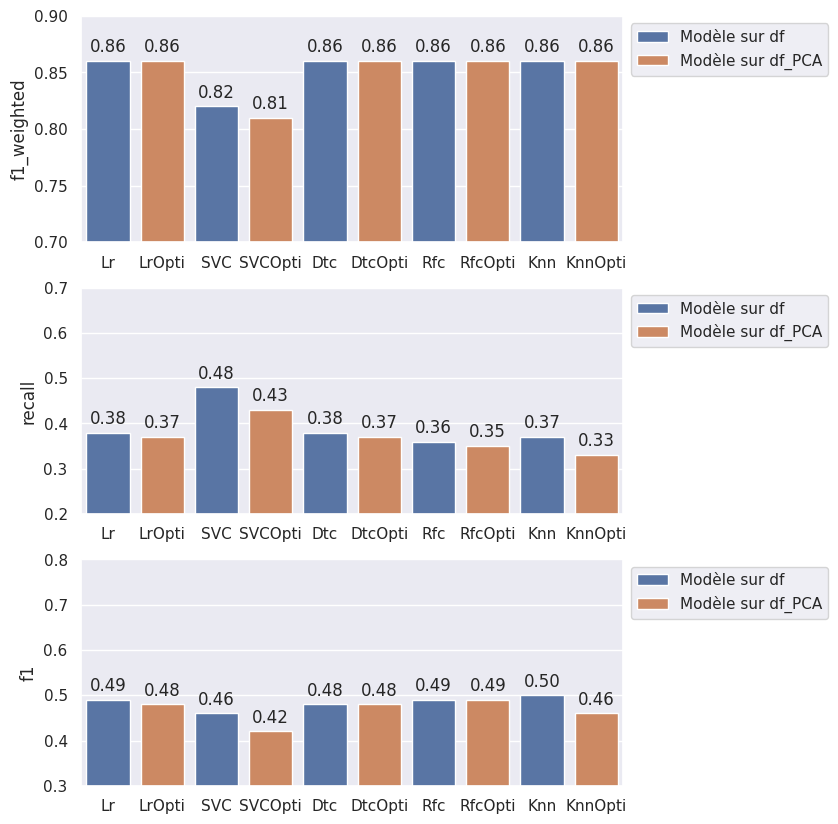

In [61]:
fig, axes = plt.subplots(3, 1)
sns.set(rc={"figure.figsize":(7, 10)})

aa = sns.barplot(data=df_print, x="nom_rac", y="f1_weighted", hue="données utilisées", dodge=False, ax=axes[0])
aa.legend(loc='upper left', bbox_to_anchor=(1, 1))
aa.set_xlabel("", fontsize=10)
aa.set_ylim([0.7, 0.9])

for p in aa.patches:
    aa.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ab = sns.barplot(data=df_print, x="nom_rac", y="recall", hue="données utilisées", dodge=False, ax=axes[1])
ab.legend(loc='upper left', bbox_to_anchor=(1, 1))
ab.set_xlabel("", fontsize=10)
ab.set_ylim([0.2, 0.7])

for p in ab.patches:
    ab.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ac = sns.barplot(data=df_print, x="nom_rac", y="f1", hue="données utilisées", dodge=False, ax=axes[2])
ac.legend(loc='upper left', bbox_to_anchor=(1, 1))
ac.set_xlabel("", fontsize=10)
ac.set_ylim([0.3, 0.8])

for p in ac.patches:
    ac.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()


## 4.2 Optimisation bayesienne <a name="4.2"></a>
[return to the plan](#1)  

In [74]:
# Définition de l'espace de recherche pour l'optimisation bayésienne
space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 15),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Real(0.1, 1.0, prior='uniform')
}

# Définition du modèle à optimiser (Random Forest)
model = RandomForestClassifier()

# Définition de l'optimiseur bayésien avec 20 itérations
opt = BayesSearchCV(
    model,
    space,
    n_iter=20,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=5
)

# Lancement de l'optimisation
opt.fit(X_train, y_train)



BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
              scoring='f1_weighted',
              search_spaces={'max_depth': Integer(low=3, high=15, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')})

In [75]:
# Affichage des meilleurs hyperparamètres trouvés
print('Meilleurs hyperparamètres :', opt.best_params_)

# Évaluation du modèle avec les hyperparamètres trouvés
score = opt.score(X_test, y_test)
print('Score de l\'optimisation bayésienne : {:.2f}'.format(score))

Meilleurs hyperparamètres : OrderedDict([('max_depth', 15), ('max_features', 0.798245942836627), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 774)])
Score de l'optimisation bayésienne : 0.87


In [80]:
# Instanciation du modèle avec les meilleurs hyperparamètres
best_model = RandomForestClassifier(
    max_depth=15,
    max_features=0.798245942836627,
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=774
)

# Entraînement du modèle sur l'ensemble des données d'entraînement
best_model.fit(X_train, y_train)

# Évaluation du modèle sur l'ensemble des données de test
score = best_model.score(X_test, y_test)
print('Score du modèle : {:.2f}'.format(score))

Score du modèle : 0.88


# Conclusion <a name="1"></a>
[return to the plan](#0)  

> <b>El ipsum vitae lacinia. Sed euismod nibh dolor</b> :
> 
> * Suspendisse vitae dui luctus, molestie felis vel, hendrerit diam. Nullam eget dui vitae eros consectetur laoreet. Aliquam sagittis orci vel augue ullamcorper, non tempor urna malesuada. Suspendisse sodales vel ipsum vitae lacinia. Sed euismod nibh dolor, eu eleifend nibh fermentum eu. Nulla facilisi. Fusce ac fringilla urna. Sed sit amet sagittis quam. Sed condimentum euismod sapien, a auctor orci maximus eget. Donec nec consequat magna. Suspendisse potenti. In sagittis varius leo, at rhoncus erat imperdiet ac. Sed nec fringilla enim, sit amet efficitur lectus.
> 
> * Pellentesque hendrerit libero at odio sagittis, id blandit nulla eleifend. Sed vel sapien a velit vestibulum blandit. Sed lobortis lobortis neque, sit amet dapibus eros accumsan eu. Sed eget erat rhoncus, pretium nibh in, bibendum nisl. Sed ac elit ut elit elementum ullamcorper. Nulla facilisi. Aliquam consectetur urna vel posuere tincidunt. Sed vel tincidunt lorem. Nam ultricies bibendum enim, vel lacinia nisl vehicula eget. Donec ut neque non mi tincidunt venenatis at nec risus. Sed sodales consectetur enim. Curabitur eget eros sem. Sed efficitur, magna at bibendum suscipit, elit purus imperdiet ex, at ultrices nulla velit eu justo. Ut placerat tincidunt est, sit amet fringilla diam finibus eu. Ut ornare tellus vel tincidunt dapibus.
> 
> * Nullam vel enim nisi. Curabitur eget aliquet nunc. Etiam euismod ornare erat, eu tempor arcu pretium id. Nunc euismod, nibh a lacinia aliquet, elit elit consectetur velit, at maximus nulla odio sed ante. Aliquam scelerisque convallis lectus vel malesuada. Vestibulum euismod urna non dolor efficitur, sit amet lobortis quam eleifend. In molestie libero in dolor iaculis, quis dapibus lectus bibendum. Sed consequat velit et ipsum auctor, eu auctor arcu vehicula. Sed vel est ipsum. Vestibulum bibendum justo non nulla euismod pretium. Proin nec nunc nec felis posuere cursus. Suspendisse pharetra diam id diam varius, vitae pellentesque odio imperdiet. Nulla quis massa eu mi molestie varius in quis est. Sed pulvinar libero et sapien semper dapibus. Sed eu

In [0]:
Modèle le plus efficace ? RandomForest
Influence du travail sur Df de base ou celui du PCA ? Gain très faible
Recherche bayesienne >> Gridsearch : A l’aveugle et sans présager des hyperparamètres importants mais temps de calcul très long.
f1-weighted globale élevée mais faible niveau de précision sur la classe 1  Préjudiciable suivant le cas d’usage


# Annexe : LazyClassifier <a name="1"></a>
[return to the plan](#0)  

On exploite la librairie LazyClassifier pour avoir une vue d'ensemble rapide de résultats des différents modèles en termes de :
* Résultats sur différents metrics
* Temps de calcul

In [34]:
clf = LazyClassifier(ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████| 29/29 [04:25<00:00,  9.17s/it]


In [35]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.75               0.75     0.75      0.78   
GaussianNB                         0.81               0.72     0.72      0.82   
BernoulliNB                        0.79               0.71     0.71      0.81   
XGBClassifier                      0.88               0.71     0.71      0.87   
QuadraticDiscriminantAnalysis      0.83               0.71     0.71      0.84   
Perceptron                         0.81               0.70     0.70      0.82   
LGBMClassifier                     0.88               0.70     0.70      0.87   
LinearDiscriminantAnalysis         0.87               0.69     0.69      0.86   
SGDClassifier                      0.87               0.68     0.68      0.86   
DecisionTreeClassifier             0.82               0.68     0.68      0.82   
RandomForestClassifier      

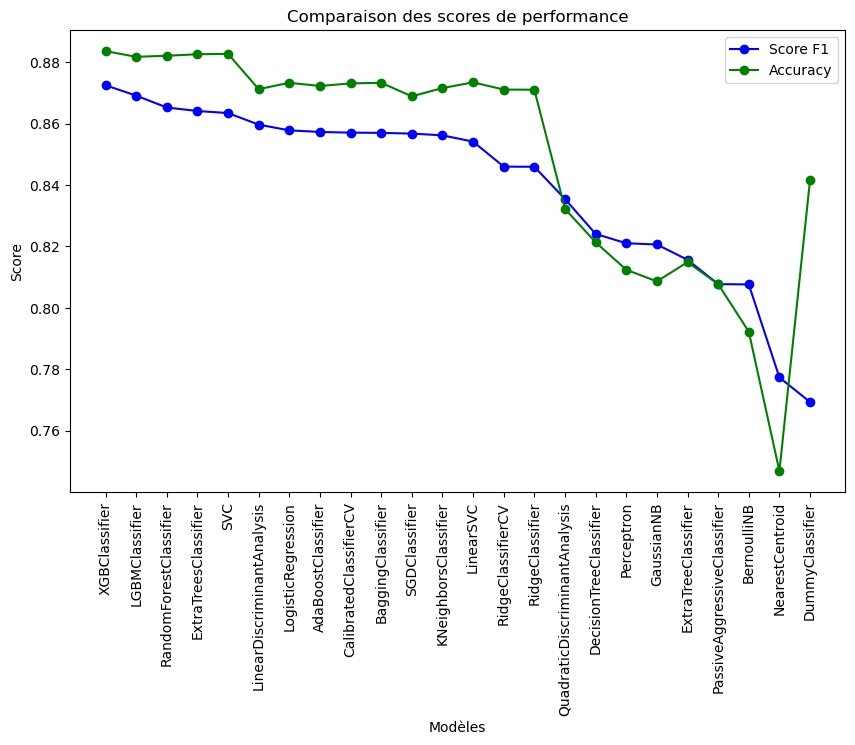

In [37]:
# Convertir les scores de performance en listes
models_list = list(models.index)
accuracy_list = list(models['Accuracy'])
f1_score_list = list(models['F1 Score'])

# Trier les listes par ordre décroissant de score F1
sorted_indices = np.argsort(f1_score_list)[::-1]
models_list = [models_list[i] for i in sorted_indices]
accuracy_list = [accuracy_list[i] for i in sorted_indices]
f1_score_list = [f1_score_list[i] for i in sorted_indices]

# Tracer la courbe de performance
plt.figure(figsize=(10, 6))
plt.plot(models_list, f1_score_list, '-o', color='blue', label='Score F1')
plt.plot(models_list, accuracy_list, '-o', color='green', label='Accuracy')
plt.xlabel('Modèles')
plt.ylabel('Score')
plt.title('Comparaison des scores de performance')
plt.xticks(rotation=90)
plt.legend()
plt.show()

On retrouve globalement les résultat obtenus manuellement au niveau des metrics avant optimisation. Cette visualisation permet cependant d'aisément voir les différences de temps de calcul (~x1000 entre la régression et le modèle SVC pour 1 centième de performance supplémentaire sur l'accuracy) 
Suivant les cas d'usage métier, il pourrait être intéressant de choisir un modèle à execution rapide.
